#### Reference: Evidence of Predictable Behavior of Security Returns by N. Jegadeesh

First we configure the notebook to show plots inline and import necessary python packages.

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            %matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

# 1. Get data for backtesting

The period for backtesting is selected to be from 01/31/2000 to 12/31/2015. The data for backtesting were downloaded from Yahoo! Finance with publicly available python modules. All data are pre-downloaded and saved in CSV files, which is read and formatted using self-defined function

In [2]:
from my_helper_fn import read_from_csv

## Stock price data

In [3]:
price_csv = 'stock_adj_close_2000_2015.csv';
stock_prices = read_from_csv( price_csv );
monthly_stock_prices = stock_prices.resample( "BM" ).last();
monthly_stock_returns = monthly_stock_prices.pct_change().iloc[1:];

# Take a peek at the data
print monthly_stock_returns.iloc[:5,:5]

                   A        AA      AAPL       ABC       ABT
Date                                                        
2000-01-31 -0.143897 -0.160392  0.009118  0.193414 -0.098862
2000-02-29  0.569405 -0.013621  0.104819 -0.196553  0.013436
2000-03-31  0.001203  0.025547  0.184842  0.030045  0.066288
2000-04-28 -0.147837 -0.076512 -0.086516  0.333333  0.097843
2000-05-31 -0.169252 -0.095731 -0.322922  0.212500  0.058536


#### Looking-forward bias

The universe of stocks is selected to be all those stocks that have been in S&P500 since 2000 through 2015. This introduces looking-forward or survivorship bias, because only those stocks that manage to remain in S&P500 are kept. The number of stocks selected is a little more than 400, so an implied assumption is that this looking-forward bias can be ignored in our backtest.

## Benchmark: S&P 500

               ^GSPC
Date                
1991-01-31  0.041518
1991-02-28  0.067281
1991-03-29  0.022203
1991-04-30  0.000320
1991-05-31  0.038605


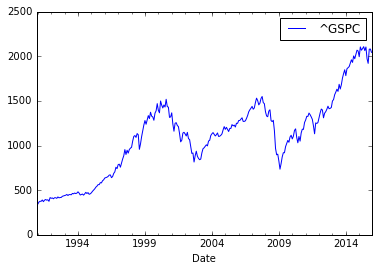

In [4]:
snp_500 = read_from_csv( "benchmark.csv" );
snp_500 = snp_500.resample( "BM" ).last();
snp_500_returns = snp_500.pct_change().iloc[1:];
benchmark_returns = snp_500_returns;

snp_500.plot( legend=True );
print benchmark_returns.iloc[:5,:];

## Risk-free rate: Rate of 13 WEEK TREASURY BILL

Raw data are annualized rates, and therefore it needs to be converted to monthly return in order to be compared with monthly stock and benchmark returns.

                ^IRX
Date                
1990-12-31  0.005214
1991-01-31  0.005018
1991-02-28  0.004899
1991-03-29  0.004662
1991-04-30  0.004480


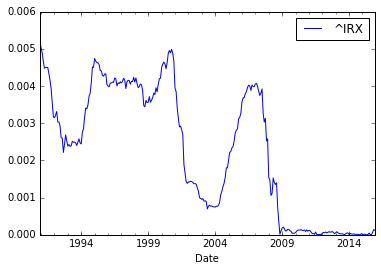

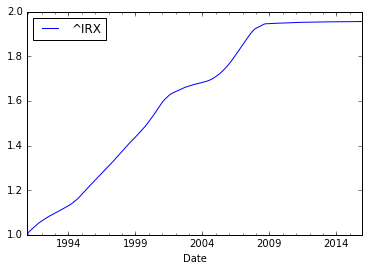

In [5]:
rf_annualized_rate = read_from_csv( "riskfree.csv", rescale_factor = 0.01 );
rf_annualized_rate = rf_annualized_rate.resample('BM').last();
def deannualization_func( annual_rate, freq="M" ):
	if freq is "M":
		return (1+annual_rate)**(1./12) - 1

rf_rate = rf_monthly_rate = rf_annualized_rate.apply( deannualization_func );
riskfree_rate = rf_rate;

print riskfree_rate.iloc[:5,:]
riskfree_rate.plot( legend=True );
(1 + riskfree_rate ).cumprod().plot( legend=True);

# 2. Test the signal

A simple idea to test the signal: rank the universe based on the result of cross-sectional autogression results, and then pick the top 10 stocks to hold for the next period.

In [6]:
from myStrategies.regression import Regression_OLS  # A strategy that's based on OLS regression

lags = range(1,13);
reg_lags_and_weights = {};
for lag in lags:
	reg_lags_and_weights[ lag ] = 1;
    
ols_strategy = Regression_OLS( 
	stock_prices,
	riskfree_rate,
	benchmark_returns,
	resample_freq = "BM",
	sample_lookback = 60,			# number of periods of looking back for training data
	reg_lags_and_weights = reg_lags_and_weights,
	num_longs = 10,					# number of stocks to long for each period
	num_shorts = 0,				# number of stocks to short for each period
);

ols_backtest_res = ols_strategy.BackTest();


We can calculate various measures in order to evaluate how the strategy performs. In particular, the strategy exhibits high beta.

In [7]:
_, ols_strategy_analysis = ols_strategy.BackTestAnalysis();
print ols_strategy_analysis;

{'CAMP': (0.067033399349011411, 1.3332234514503363), 'Annualized Average Return': 0.14208349924744812, 'Sortino': 0.73861342496242666, 'Sharpe': 0.50016302860703432, 'Info_Ratio': 0.4711980150621804, 'Annualized Volatility': 0.26354747466617795}


### Drawdown

By plotting the cumulative return of the strategy, we noticed large drawdown during the financial crisis and recent market turmoil.

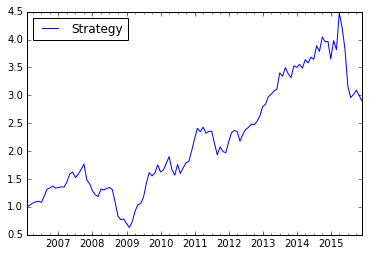

In [8]:
plt.figure();
ols_backtest_res[ "cum_strategy" ].plot( legend = True);

### Look into regression results

In Jagadeesh's paper, it was claimed that first order coefficient is in general negative. By plotting the regression coefficient, we do observe "abnormal" behavior from Jagadeesh's claim. We also plot the 95% confidence interval for each step to show its statistical significance.

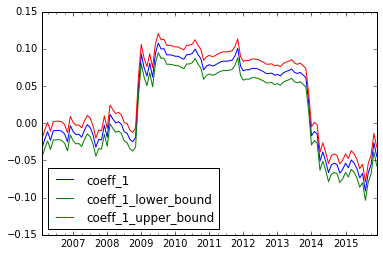

In [9]:
plt.figure();
ols_strategy.reg_coefficients_df.loc[:,"coeff_1"].plot( legend = True );

coeff1_lb_arr = list(); # Lower bound for 1st order regression coefficient
coeff1_ub_arr = list(); # Upper bound for 1st order regression coefficient
for reg_result in ols_strategy.reg_result_hist_df:
    coeff1_lb_arr.append( reg_result.conf_int()[1,0] );    
    coeff1_ub_arr.append( reg_result.conf_int()[1,1] );    

reg_result_index = ols_strategy.reg_result_hist_df.index;
coeff1_lb_series = pd.Series( coeff1_lb_arr, index=reg_result_index, name = "coeff_1_lower_bound" );
coeff1_ub_series = pd.Series( coeff1_ub_arr, index=reg_result_index, name = "coeff_1_upper_bound" );

coeff1_lb_series.plot( legend = True );
coeff1_ub_series.plot( legend = True );
                  

### Test on OLS assumptions

It is important to test the basic assumptions for OLS regression. Below I show the p-values for normality test and heteroskedasticity test. It looks like, with the above setting (a lookback window of 60 months), the OLS residual satisfies both assumptions on normality and heteroskedasticity.

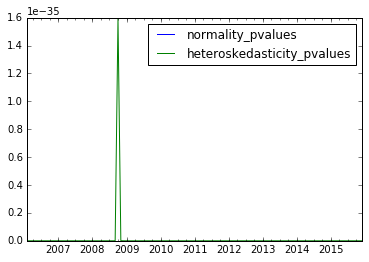

In [10]:
plt.figure();
ols_strategy.normality_pvalues_series.plot( legend=True );
ols_strategy.heteroskedasticity_pvalues_series.plot( legend=True );

# 3. Vary number of lags in OLS

In [11]:
# Construct the same OLS strategy but with only 1 lag
lags = range(1,2);
reg_lags_and_weights = {};
for lag in lags:
	reg_lags_and_weights[ lag ] = 1;
    
ols1_strategy = Regression_OLS( 
	stock_prices,
	riskfree_rate,
	benchmark_returns,
	resample_freq = "BM",
	sample_lookback = 60,			# number of periods of looking back for training data
	reg_lags_and_weights = reg_lags_and_weights,
	num_longs = 10,					# number of stocks to long for each period
	num_shorts = 0,				# number of stocks to short for each period
);

ols1_backtest_res = ols1_strategy.BackTest();

We can compare the results of 1 lag with the previous one with all 12 lags. Overall, the OLS strategy with 1 lag appears to be more volatile, which is reflected in both Beta and strategy volatility.

12-lag OLS Strategy
{'CAMP': (0.067033399349011411, 1.3332234514503363), 'Annualized Average Return': 0.14208349924744812, 'Sortino': 0.73861342496242666, 'Sharpe': 0.50016302860703432, 'Info_Ratio': 0.4711980150621804, 'Annualized Volatility': 0.26354747466617795} 

1-lag OLS Strategy
{'CAMP': (0.059062552362514203, 1.4155113549616631), 'Annualized Average Return': 0.13862704289290889, 'Sortino': 0.57172611481376379, 'Sharpe': 0.45563634405961795, 'Info_Ratio': 0.40631413861013332, 'Annualized Volatility': 0.27725177968053455}


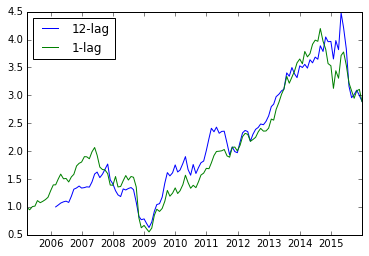

In [12]:
plt.figure();
plt.plot( ols_backtest_res[ "cum_strategy" ].index, ols_backtest_res[ "cum_strategy" ].values, label = "12-lag" );
plt.plot( ols1_backtest_res[ "cum_strategy" ].index, ols1_backtest_res[ "cum_strategy" ].values, label = "1-lag" );
plt.legend( loc = 2 );

_, ols_strategy_analysis = ols_strategy.BackTestAnalysis();
_, ols1_strategy_analysis = ols1_strategy.BackTestAnalysis();

print "12-lag OLS Strategy\n", ols_strategy_analysis, "\n";
print "1-lag OLS Strategy\n", ols1_strategy_analysis;

# 4. Dynamically adjust regression coefficient - Kalman Filter

As an attempt to dynamically adjust regression coefficient, I built a strategy based on Kalman Filter, where only 1st order coefficient is included. Therefore it is natural to compare this strategy with the OLS strategy of 1 lag.

In [13]:
from myStrategies.kalmanfilter import RegressionKalmanFilter

kf_strategy = RegressionKalmanFilter(
	stock_prices,
	riskfree_rate,
	benchmark_returns,
	resample_freq = "BM",
	num_longs = 10,					# number of stocks to long for each period
	num_shorts = 0,				# number of stocks to short for each period
);

kf_backtest_res = kf_strategy.BackTest();

Compared with OLS strategy, KalmanFilter appears to have higher beta and higher Sharpe Ratio, too.

In [14]:
print "OLS Strategy with one lag:\n", ols1_strategy.BackTestAnalysis()[1], "\n";
print "Kalman-Filter Strategy with one lag:\n", kf_strategy.BackTestAnalysis()[1];

OLS Strategy with one lag:
{'CAMP': (0.059062552362514203, 1.4155113549616631), 'Annualized Average Return': 0.13862704289290889, 'Sortino': 0.57172611481376379, 'Sharpe': 0.45563634405961795, 'Info_Ratio': 0.40631413861013332, 'Annualized Volatility': 0.27725177968053455} 

Kalman-Filter Strategy with one lag:
{'CAMP': (0.15929847444979772, 1.5933890369923427), 'Annualized Average Return': 0.20668523966087582, 'Sortino': 0.85543357207855653, 'Sharpe': 0.57910374628805594, 'Info_Ratio': 0.69897977641166809, 'Annualized Volatility': 0.3319470550297749}


Plots of returns: Kalman-Filter appears to outperform the OLS strategy with 1-lag.

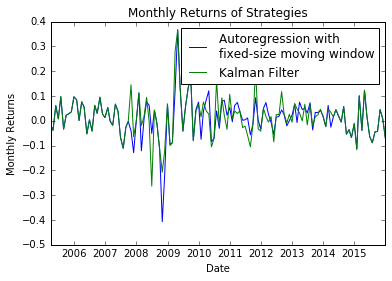

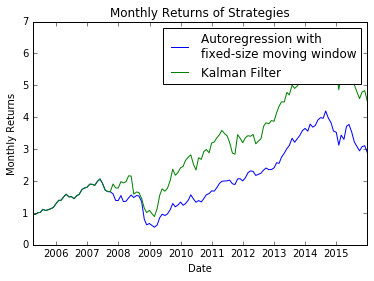

In [15]:
# Take the common period between two strategies
common_start = max( ols1_backtest_res["strategy"].index[0], kf_backtest_res["strategy"].index[0] );

ols1_strategy_monthly = ols1_backtest_res['strategy'].loc[ common_start:];
kf_monthly = kf_backtest_res[ "strategy" ].loc[common_start:];

ols1_strategy_cum_returns = (1 + ols1_strategy_monthly ).cumprod();
kf_cum_returns = (1 + kf_monthly ).cumprod();

# Plot monthly returns and cumulative returns for both strategies
fig1 = plt.figure(1);
plt.plot( ols1_strategy_monthly.index, ols1_strategy_monthly.values, label = "Autoregression with\nfixed-size moving window" );
plt.plot( kf_monthly.index, kf_monthly.values, label = "Kalman Filter" );
plt.xlabel( "Date" );
plt.ylabel( "Monthly Returns" );
plt.title( "Monthly Returns of Strategies" );
plt.legend();

fig2 = plt.figure(2);
plt.plot( ols1_strategy_monthly.index, ols1_strategy_cum_returns.values, label = "Autoregression with\nfixed-size moving window" );
plt.plot( kf_cum_returns.index, kf_cum_returns.values, label = "Kalman Filter" );
plt.xlabel( "Date" );
plt.ylabel( "Monthly Returns" );
plt.title( "Monthly Returns of Strategies" );
plt.legend();

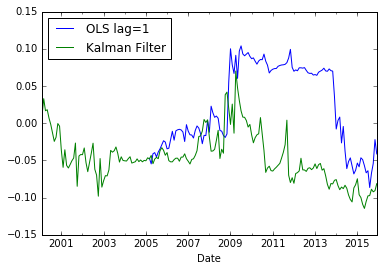

In [16]:
ols1_slope = ols1_strategy.reg_coefficients_df.loc[:,"coeff_1"];
kf_slope = kf_strategy.kf_coefficients_df.loc[:,"coeff_1"];

ols1_slope.rename( "OLS lag=1", inplace = True );
kf_slope.rename( "Kalman Filter", inplace = True );

ols1_slope.plot( legend=True);
kf_slope.plot( legend=True );

# 5. Design strategy for strategy entry and exit

Either the OLS strategy or Kalman Filter strategy is essentially a stock-ranking mechanism for predicting the positions for next period. All the strategies above exhibits large drawdown during the financial crisis and recent market turmoil, which indicates the failure of the ranking systems. A natural question to ask is:

How good is the prediction?

## 5.1 Compare prediction with real returns (OLS strategy as an example)

A few intuitive measures are examined at each period t (let Pred_t be the prediction made at time t-1, and real_t be the real return at t):
1. Standard deviation of real_t - pred_t
2. Correlation coefficient between real_t and pred_t
3. Spearman Ranking coefficient and its p-value

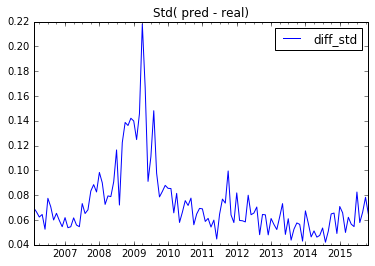

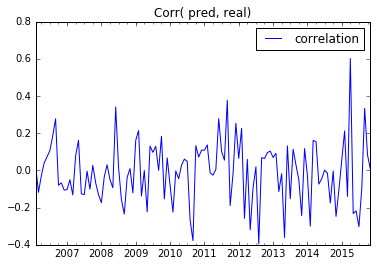

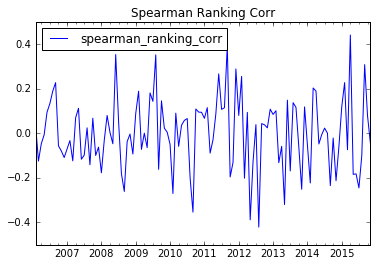

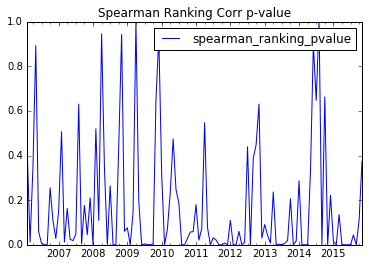

In [17]:
plt.figure();
ols_backtest_res[ 'pred_vs_real_df' ].loc[:,"diff_std"].plot( legend=True );
plt.title( "Std( pred - real)" );

plt.figure();
ols_backtest_res[ 'pred_vs_real_df' ].loc[:,"correlation"].plot( legend=True );
plt.title( "Corr( pred, real)" );

plt.figure();
ols_backtest_res[ 'pred_vs_real_df' ].loc[:,"spearman_ranking_corr"].plot( legend=True );
plt.title( "Spearman Ranking Corr" );

plt.figure();
ols_backtest_res[ 'pred_vs_real_df' ].loc[:,"spearman_ranking_pvalue"].plot( legend=True );
plt.title( "Spearman Ranking Corr p-value" );


## 5.2 Design Entry/Exit strategy

It seems the standard deviation of prediction residual and the p-value of Spearman Ranking Correlation are good indicators of how good the OLS regression is for predicting the returns and rankings. Therefore I design the following entry/exit strategy. At time t, we look at pred(t-1) and real(t-1). 

We would enter the strategy if both criterion below are satisfied:
(1) Std[ pred(t-1) - real(t-1) ] < 0.1 (or some other calculated metric such as std[ real(t-1)] ); 
(2) Spearman Ranking Corr: p-value < 0.05
(3) Average strategy return > 0

Otherwise, we exit the strategy and invest in risk-free asset.

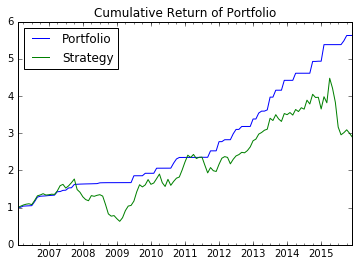

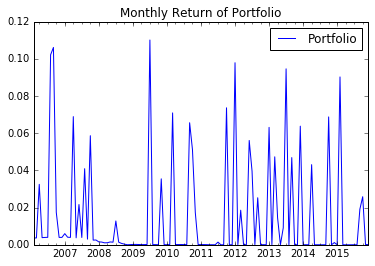

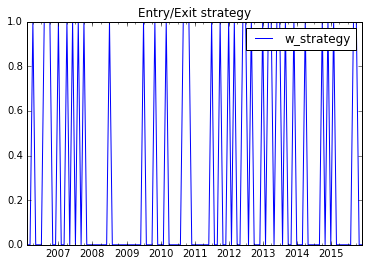

In [18]:
plt.figure();
ols_backtest_res[ "cum_portfolio" ].plot( legend = True );
ols_backtest_res[ "cum_strategy" ].plot( legend = True );
plt.title( "Cumulative Return of Portfolio" );

plt.figure();
ols_backtest_res[ "portfolio" ].plot( legend=True );
plt.title( "Monthly Return of Portfolio" );

plt.figure();
ols_backtest_res[ "asset_weights" ].loc[:,"w_strategy"].plot( legend = True );
plt.title( "Entry/Exit strategy" );

The result above shows that the Entry/Exit strategy would have effectively prevent the portfolio from large drawdowns. It also has much fewer rebalances for the time span of +10 years. The portfolio as a whole has a much lower beta to the benchmark but a much higher Sharpe Ratio

In [19]:
portfolio_analysis, strategy_analysis = ols_strategy.BackTestAnalysis();
print "Portfolio :\n", portfolio_analysis, "\n";
print "Strategy:\n", strategy_analysis

Portfolio :
{'CAMP': (0.15672074472883302, 0.26434258275800687), 'Annualized Average Return': 0.19544174748103882, 'Sortino': 23.406565058510701, 'Sharpe': 1.7701855087085596, 'Info_Ratio': 0.8556968328937502, 'Annualized Volatility': 0.096152879534837823} 

Strategy:
{'CAMP': (0.067033399349011411, 1.3332234514503363), 'Annualized Average Return': 0.14208349924744812, 'Sortino': 0.73861342496242666, 'Sharpe': 0.50016302860703432, 'Info_Ratio': 0.4711980150621804, 'Annualized Volatility': 0.26354747466617795}


## 5.3 Example: Kalman Filter

We can apply the same idea to the strategy based on Kalman Filter.

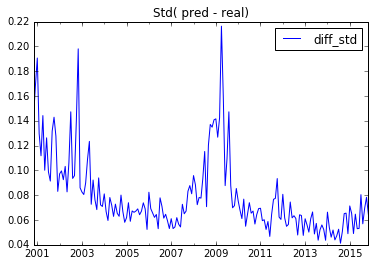

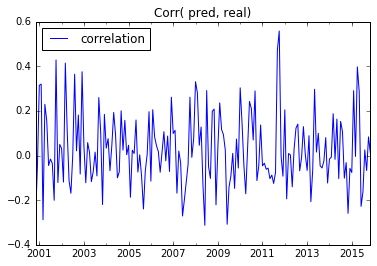

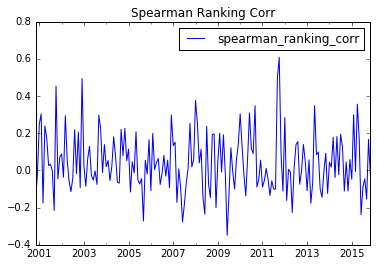

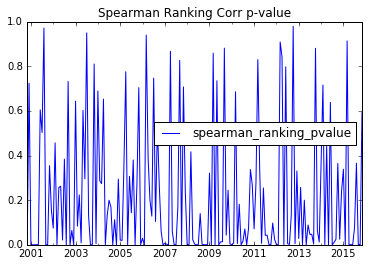

In [20]:
plt.figure();
kf_backtest_res[ 'pred_vs_real_df' ].loc[:,"diff_std"].plot( legend=True );
plt.title( "Std( pred - real)" );

plt.figure();
kf_backtest_res[ 'pred_vs_real_df' ].loc[:,"correlation"].plot( legend=True );
plt.title( "Corr( pred, real)" );

plt.figure();
kf_backtest_res[ 'pred_vs_real_df' ].loc[:,"spearman_ranking_corr"].plot( legend=True );
plt.title( "Spearman Ranking Corr" );

plt.figure();
kf_backtest_res[ 'pred_vs_real_df' ].loc[:,"spearman_ranking_pvalue"].plot( legend=True );
plt.title( "Spearman Ranking Corr p-value" );

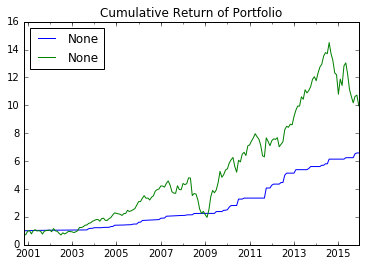

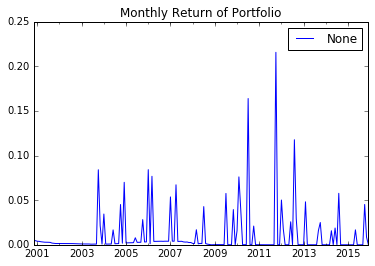

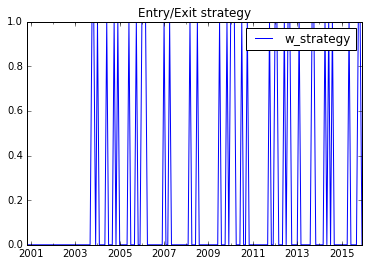

In [21]:
plt.figure();
kf_backtest_res[ "cum_portfolio" ].plot( legend = True );
kf_backtest_res[ "cum_strategy" ].plot( legend = True );
plt.title( "Cumulative Return of Portfolio" );

plt.figure();
kf_backtest_res[ "portfolio" ].plot( legend=True );
plt.title( "Monthly Return of Portfolio" );

plt.figure();
kf_backtest_res[ "asset_weights" ].loc[:,"w_strategy"].plot( legend = True );
plt.title( "Entry/Exit strategy" );

In [22]:
kf_portfolio_analysis, kf_strategy_analysis = kf_strategy.BackTestAnalysis();
print "Portfolio :\n", kf_portfolio_analysis, "\n";
print "Strategy:\n", kf_strategy_analysis

Portfolio :
{'CAMP': (0.11029696987150719, 0.20456124705534745), 'Annualized Average Return': 0.13683110020725486, 'Sortino': 39.024524402750295, 'Sharpe': 1.2174872054137278, 'Info_Ratio': 0.62752452212645282, 'Annualized Volatility': 0.093813954514958886} 

Strategy:
{'CAMP': (0.15929847444979772, 1.5933890369923427), 'Annualized Average Return': 0.20668523966087582, 'Sortino': 0.85543357207855653, 'Sharpe': 0.57910374628805594, 'Info_Ratio': 0.69897977641166809, 'Annualized Volatility': 0.3319470550297749}


# 6. Summary

## 6.1 What has been done and learned

1. US stock market exhibits predictability from historical returns.
2. Quality of prediction is influenced by model selection: number of features, length of lookback window, etc.
3. Kalman Filter can be used as a dynamic Bayesian estimate for autoregression coefficients.
4. Entry/Exit strategy can help reduce drawdown and improve Sharpe ratio

## 6.2 What's next?

1. Extend one-lag Kalman Filter to multiple lags
2. Look at intraday v.s. interday
3. Identify crossectional clusters and apply autoregression within each cluster
4. Make the entry/exit strategy "smarter"
5. ...